# Modeling

## Importing modules and data

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
plt.style.use('fivethirtyeight')

In [23]:
random.seed(32)

In [24]:
df = pd.read_csv('../data/nbacomments_processed.csv')

In [25]:
df.shape

(42199, 8)

Let's do another check for null values and drop them:

In [26]:
df.text.isnull().sum()

2

In [27]:
df[df.text.isnull()]

,affiliation,text,thread_id,ups,when_comment_posted,team1,team2,participation
33476,Warriors,NaN,8i2d2p,27,1.525840e+09,Pelicans,Warriors,1
40381,Cavaliers,NaN,8m63dg,10,1.527305e+09,Celtics,Cavaliers,1


In [28]:
df.drop([33476, 40381], 0, inplace=True)

## Creating Validation Set, Vectorizing Text

In [29]:
X = df.text.values
y = df.participation

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Addressing imbalanced classes

In our data we had a 2:1 ratio of nonparticipants to participants; the imbalanced nature of the target class will impact the ability of our models to discern between the classes. I will oversample the positive class (participants) so that there is an approximate 1:1 ratio of participants to nonparticipants in the training data.

In [30]:
oversampler = RandomOverSampler(random_state=32)

In [32]:
tv = TfidfVectorizer(strip_accents='ascii', ngram_range = (1,2), min_df=3, stop_words='english')
X_train_tvs = tv.fit_transform(X_train.astype('str'))
X_test_tvs = tv.transform(X_test.astype('str'))

In [34]:
X_train_ovs, y_train = oversampler.fit_sample(X_train_tvs, y_train)

I chose to detect posts from participating fans, so those are represented by 1s while posts from nonparticipating fans are represented by 0s; we have approximately a 2:1 ratio of nonparticipants to participants. 

In a confusion matrix, true positives would thus be the true number of participants identified out of all 1s predicted by the model, and true negatives would be the true number of non-participants out of all the 0s predicted by the model.

## Metrics function

In [62]:
def get_metrics(y_true, y_predict):
    matrix_def = [['tn','fp'], ['fn','tp']]
    matrix = confusion_matrix(y_true, y_predict)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    misclass = 1-accuracy
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    print('Matrix Definition')
    print(np.array(matrix_def))
    print('')
    print('Confusion Matrix')
    print(matrix)
    print('')
    print('METRICS')
    print(f'accuracy: {accuracy}')
    print(f'misclass: {misclass}')
    print(f'sensitivity: {sensitivity}')
    print(f'specificity: {specificity}')

## Logistic Regression

Logistic regression for text classification is a model where the log-odds of the probability of a success is the linear combination of the frequency (in this case the TF/IDF scaled frequency). `C` is the inverse regularization strength (larger values imply weaker regularization). `L1` and `L2` are the regularization norms (analogous to L1/Lasso regularization and L2/Ridge regularization in linear regression models).

In [44]:
grid_logreg = GridSearchCV(LogisticRegression(), param_grid = {'penalty': ['l1', 'l2'], 
                                                               'C': [1e3, 1e4, 1e5]})

In [45]:
%%time
grid_logreg.fit(X_train_ovs, y_train)

Wall time: 1min 45s


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1000.0, 10000.0, 100000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
grid_logreg.score(X_train_ovs, y_train), grid_logreg.score(X_test_tvs, y_test)

(0.8798143963071597, 0.5674881516587678)

In [40]:
precision_score(y_test, grid_logreg.predict(X_test_tvs))

0.39504504504504506

In [49]:
roc_auc_score(y_test, grid_logreg.predict(X_test_tvs))

0.5474280645032504

In [50]:
grid_logreg.best_params_

{'C': 1000.0, 'penalty': 'l2'}

In [51]:
log_df_2 = pd.DataFrame(grid_logreg.best_estimator_.coef_, columns=tv.get_feature_names())

In [52]:
log_df_2.T.sort_values(0, ascending=False).head(10)

,0
shit look,56.836393
big ass,53.936993
theres just,50.876397
fuck play,50.253866
gg cavs,49.258396
hes hot,47.947889
gg wolves,46.990958
talk series,46.652766
having play,46.158953
end day,45.782066


In [53]:
log_df_2.T.sort_values(0, ascending=False).tail(10)

,0
draymond like,-47.616986
calls going,-48.081052
married,-49.184251
da fuck,-49.536380
bored,-50.091761
flipping,-51.138260
game point,-54.652539
ass fouls,-58.172721
look easy,-61.875518
gobert looks,-61.915460


###  Setting up dataframe for plotting

In [54]:
bar_positive = log_df_2.T.sort_values(0, ascending=False).head(10)

bar_negative = log_df_2.T.sort_values(0, ascending=False).tail(10)

log_bar = bar_positive.append(bar_negative)

log_bar.rename(columns={0: 'coefficient'}, inplace=True)

log_bar['text'] = log_bar.index

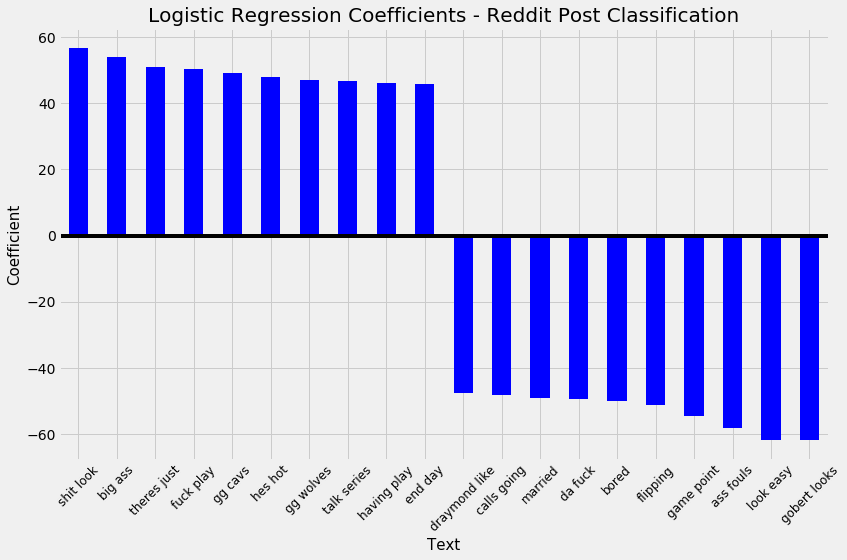

In [55]:
fig = log_bar.plot.bar('text', 'coefficient', figsize=(12, 8), legend=False, cmap='winter')
fig.set_xlabel('Text', size=15)
plt.xticks(size=12, rotation=45)
plt.axhline(color='black')
fig.set_ylabel('Coefficient', size=15)
fig.set_title('Logistic Regression Coefficients - Reddit Post Classification', size=20);
plt.tight_layout()

###  Interpretation

This plot shows the top 10 most positive and the top 10 most negative coefficients of the grid searched logistic regression model. Text tokens with negative coefficients contributed heavily to posts being classified as made by non-participants, while text with positive coefficients is associated with posts being classified as made by participants.

##  Decision Tree Classifier

The decision tree classifier breaks down the data in a tree-wise fashion, creating decision nodes where the algorithm decides to split the dataset using a criterion that maxmizes information gain in order to establish leaf nodes. Leaf nodes are those where the data contained within all contribute the same information to the algorithm. 

In [57]:
dt_params = {'min_samples_split': [2, 3, 4],
             'min_samples_leaf': [2]}

In [58]:
%%time
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = dt_params)
grid_dt.fit(X_train_ovs, y_train)

Wall time: 1min 50s


In [59]:
grid_dt.score(X_train_ovs, y_train)

0.9357118815213733

In [60]:
grid_dt.score(X_test_tvs, y_test)

0.6050236966824645

In [63]:
get_metrics(y_test, grid_dt.predict(X_test_tvs))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[5190 1729]
 [2438 1193]]

METRICS
accuracy: 0.6050236966824645
misclass: 0.3949763033175355
sensitivity: 0.32855962544753514
specificity: 0.7501083971672207


In [64]:
grid_dt.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 3}

In [65]:
roc_auc_score(y_test, grid_dt.predict(X_test_tvs))

0.5393340113073779

In [66]:
grid_dt.best_estimator_.feature_importances_

array([0.        , 0.00016254, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [67]:
dt_df = pd.DataFrame(grid_dt.best_estimator_.feature_importances_, tv.get_feature_names())

In [68]:
dt_bar = dt_df.sort_values(0, ascending=False).head(10)

In [69]:
dt_bar['text'] = dt_bar.index

In [70]:
dt_bar.rename(columns={0: 'Importance'}, inplace=True)

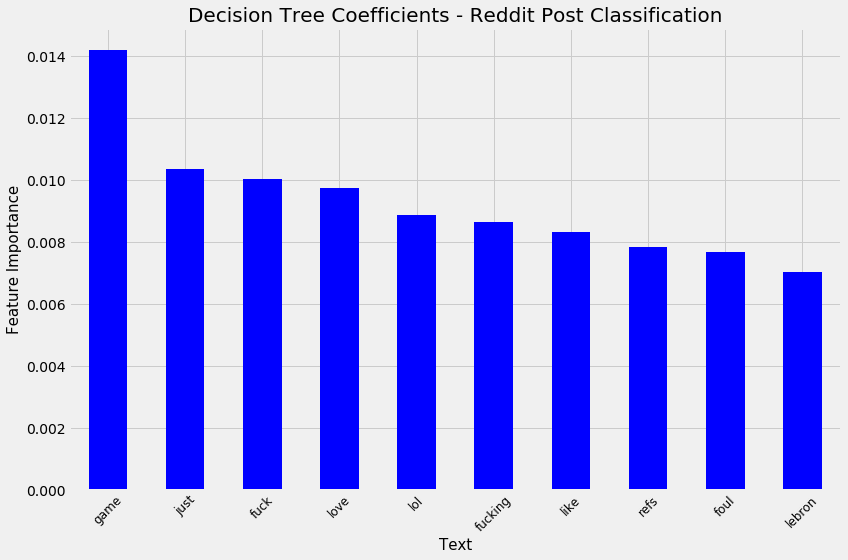

In [71]:
fig = dt_bar.plot.bar('text', 'Importance', figsize=(12, 8), legend=False, cmap='winter')
fig.set_xlabel('Text', size=15)
fig.set_ylabel('Feature Importance', size=15)
plt.xticks(rotation=45, size=12)
fig.set_title('Decision Tree Coefficients - Reddit Post Classification', size=20);
plt.tight_layout()

###  Interpretation

Feature importances refer to the total reduction of the impurity criterion (in this case, Gini impurity) provided by splitting on the associated figure. In this decision tree, splitting classes by the word 'just' contributed the most to the classification algorithm.

## SVM

The support vector machine maps data points in space and aims to find a linear boundary between classes, using the kernel trick to create a hyperplane that would divide the data in a higher dimensional space.

In [36]:
%%time
grid_svm = GridSearchCV(SVC(), param_grid = {'kernel': ['rbf'],
                                             'random_state': [32],
                                             'gamma': [0.1, 0.05, 0.001]})
grid_svm.fit(X_train_tvs, y_train)

CPU times: user 21min 13s, sys: 868 ms, total: 21min 14s
Wall time: 21min 14s


In [41]:
grid_svm.score(X_train_tvs, y_train)

0.72688447576339954

In [38]:
grid_svm.score(X_test_tvs, y_test)

0.64327402135231315

In [39]:
get_metrics(y_test, grid_svm.predict(X_test_tvs))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[4063 2866]
 [2146 4975]]

METRICS
accuracy: 0.6432740213523132
misclass: 0.35672597864768685
sensitivity: 0.6986378317652016
specificity: 0.586376100447395


In [42]:
grid_svm.best_params_

{'gamma': 0.1, 'kernel': 'rbf', 'random_state': 32}

In [59]:
roc_auc_score(y_test, grid_svm.predict(X_test_tvs))

0.64250696610629832

## Random Forest Classifier

A random forest fits a number of decision tree classifiers on sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The samples are drawn with replacement to produce samples of the same size as the originally input data.

In [44]:
%%time
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [50, 100],
                                                             'n_jobs': [-1],
                                                             'min_samples_split': [3],
                                                             'min_samples_leaf': [2]})
grid_rf.fit(X_train_tvs, y_train)

CPU times: user 4min 18s, sys: 120 ms, total: 4min 18s
Wall time: 2min 11s


In [46]:
grid_rf.score(X_train_tvs, y_train)

0.84414074548603701

In [47]:
grid_rf.score(X_test_tvs, y_test)

0.67124555160142352

In [48]:
grid_rf.best_params_

{'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100,
 'n_jobs': -1}

In [49]:
get_metrics(y_test, grid_rf.predict(X_test_tvs))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[5146 1783]
 [2836 4285]]

METRICS
accuracy: 0.6712455516014235
misclass: 0.3287544483985765
sensitivity: 0.6017413284651032
specificity: 0.7426757107807764


In [60]:
roc_auc_score(y_test, grid_rf.predict(X_test_tvs))

0.67220851962293982

## Bagging Classifier

A bagging classifier (short for bootstrap aggregating) classifier fits many classifiers onto random samples of the original data and averages them to generate a prediction. In this case shown below, I average the results of 10 decision trees. Bagging estimators are an effective way to reduce the variance of a single estimator.

### Bagging Decision Tree

In [53]:
grid_bag = GridSearchCV(BaggingClassifier(), param_grid={'n_estimators': [10],
                                                         'random_state': [32]})
grid_bag.fit(X_train_tvs, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10], 'random_state': [32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
grid_bag.score(X_train_tvs, y_train)

0.9517173823743167

In [55]:
grid_bag.score(X_test_tvs, y_test)

0.637914691943128

In [56]:
get_metrics(y_test, grid_bag.predict(X_test_tvs))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[5772 1157]
 [2663  958]]

METRICS
accuracy: 0.637914691943128
misclass: 0.362085308056872
sensitivity: 0.26456779895056615
specificity: 0.8330206378986866


In [58]:
roc_auc_score(y_test, grid_bag.predict(X_test_tvs))

0.5487942184246264

###  Bagging Random Forest

In [62]:
grid_bag_2 = GridSearchCV(BaggingClassifier(), param_grid={'base_estimator': [RandomForestClassifier()],
                                                           'n_estimators': [10],
                                                           'random_state': [32]})
grid_bag_2.fit(X_train_tvs, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)], 'n_estimators': [10], 'random_state': [32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
grid_bag_2.score(X_train_tvs, y_train)

0.9114608019717508

In [64]:
grid_bag_2.score(X_test_tvs, y_test)

0.6564928909952606

In [65]:
get_metrics(y_test, grid_bag_2.predict(X_test_tvs))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[6271  658]
 [2966  655]]

METRICS
accuracy: 0.6564928909952606
misclass: 0.34350710900473935
sensitivity: 0.18088925711129522
specificity: 0.9050368018473084


In [66]:
roc_auc_score(y_test, grid_bag_2.predict(X_test_tvs))

0.5429630294793019

## Gradient Boosting

Gradient boosting produces an ensemble of weak trees additively - shallow trees that only perform a low number of splits - and optimizes a loss function at many differentiable points by adding estimators to fit the error for each preceding model.

In [62]:
%%time
grid_grb = GridSearchCV(GradientBoostingClassifier(), param_grid={'n_estimators': [100, 500],
                                                                  'max_depth': [2, 3],
                                                                  'min_samples_split': [3],
                                                                  'min_samples_leaf': [2],
                                                                  'subsample': [0.75, 1]})
grid_grb.fit(X_train_tvs, y_train)

CPU times: user 17min 48s, sys: 4 ms, total: 17min 48s
Wall time: 17min 48s


In [63]:
grid_grb.score(X_train_tvs, y_train)

0.70847272640994619

In [65]:
grid_grb.score(X_test_tvs, y_test)

0.63444839857651247

In [66]:
grid_grb.best_params_

{'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 500,
 'subsample': 0.75}

In [67]:
get_metrics(y_test, grid_grb.predict(X_test_tvs))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[3969 2960]
 [2176 4945]]

METRICS
accuracy: 0.6344483985765125
misclass: 0.3655516014234875
sensitivity: 0.6944249403173711
specificity: 0.5728099292827248


In [68]:
roc_auc_score(y_test, grid_grb.predict(X_test_tvs))

0.63361743480004795

##  Model Selection

The final results of our model testing are as follows:

| Model                   	| Accuracy 	|  ROC AUC 	| Fit Time 	|
|-------------------------	|----------	|--------	|---------	|
| Logistic Regression     	| 0.671    	| 0.552  	| 0 min 46s       	|
| Decision Tree           	| 0.604    	| 0.534   	| 2 min 24s       	|
| SVM                     	| 0.643    	| 0.643   	| 21 min 14s      	|
| Random Forest           	| 0.671    	| 0.672   	| 2 min 11s       	|
| Bagging (Decision Tree) 	| 0.638   	| 0.574  	| 9 min 48s       	|
| Bagging (Random Forest) 	| 0.656    	| 0.543   	| 6 min 0s        	|
| Gradient Boosting       	| 0.634    	| 0.634   	| 17 min 48s      	|

Based on these results, I determined that the **Random Forest** model was the best model for our application as it offered the best balance of speed and effectiveness. Of note, the Logistic Regression model was the fastest to fit and generate scores better than some of the computationally intense models such as SVM and Gradient Boosting.